# Model Explainability Example

This notebook demonstrates how to use the `explainability` module to understand predictions from trained solar radiation forecasting models. It covers:

1. Setting up parameters (model type, paths, etc.)
2. Loading data and a pre-trained model.
3. Creating an appropriate explainer (SHAP or Sensitivity Analyzer).
4. Preparing data samples for explanation.
5. Running the explanation process.
6. Visualizing results (feature importance, sensitivity plots).

**Note:** You need to provide paths to your trained model and test data.

## 1. Imports and Setup

In [1]:
# Load autoreload extension
%load_ext autoreload
# Set autoreload to mode 2
%autoreload 2

import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from pathlib import Path
from torch.utils.data import DataLoader
from datetime import datetime

# Import project modules
from utils.explainer import ShapExplainer, SensitivityAnalyzer
from utils.timeseriesdataset import TimeSeriesDataset
from utils.model_utils import load_model
from utils.plot_utils import plot_predictions_over_time
from utils.data_persistence import load_scalers, load_normalized_data

# Configure plot style
plt.style.use('seaborn-v0_8-whitegrid')
# Timestamp the plot
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Set random seed
np.random.seed(42)

pvlib not available, using default solar position calculation


## 2. Configuration Parameters

Set the parameters for the explanation process. These correspond to the command-line arguments in the original script.

In [2]:
# --- Configuration ---
MODEL_PATH = 'checkpoints/Informer_best_20250430_214758.pt' # <<< --- IMPORTANT: Set path to your trained model file
SCALER_PATH = 'data/processed/scalers_20250430_145206.pkl' # <<< --- IMPORTANT: Set path to your scaler file
TRAIN_PREPROCESSED_DATA_PATH = 'data/processed/train_normalized_20250430_145157.h5' # <<< --- IMPORTANT: Set path to your train data file
TEST_PREPROCESSED_DATA_PATH = 'data/processed/test_normalized_20250430_145205.h5' # <<< --- IMPORTANT: Set path to your test data file
LOOKBACK = 24      # Lookback window used during model training
BATCH_SIZE = 64    # Batch size for data loading
N_SAMPLES = 1000    # Number of explanation samples from the test set to use
BACKGROUND_SIZE = 20  # Number of background samples from the training set to use
OUTPUT_DIR = 'explainability' # Directory to save results
SHAP_ALGORITHM = 'kernel' # SHAP algorithm ('kernel', 'deep', 'gradient') - relevant only if using SHAP
# ---

# Create output directory
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Model Path: {MODEL_PATH}")
print(f"Data Path: {TEST_PREPROCESSED_DATA_PATH}")
print(f"Output Directory: {output_dir}")

Model Path: checkpoints/Informer_best_20250430_214758.pt
Data Path: data/processed/test_normalized_20250430_145205.h5
Output Directory: explainability


## 3. Load Data and Model

### 3.1 Load Model and Metadata

In [3]:
# Load model and metadata first
print(f"Loading model from {MODEL_PATH}...")
try:
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Let load_model handle the model class loading
    model, model_metadata = load_model(MODEL_PATH, device=device)
    print("Model loaded successfully.")

    # Ensure model is on the correct device
    model = model.to(device)

    # Extract feature information from model metadata
    temporal_features = model_metadata.get('temporal_features', [])
    static_features = model_metadata.get('static_features', [])
    time_feature_keys = model_metadata.get('time_feature_keys', [])
    target_field = model_metadata.get('target_field', 'ghi')
    model_type = model_metadata.get('model_type', '')

    # Print model summary
    print("\n===== Model Summary =====")
    print(model)
    print("========================\n")

    # Check and print input size info from metadata
    input_size = model_metadata.get('input_size', None)
    hidden_size = model_metadata.get('hidden_size', None)
    print(f"Model type: {model_type}")
    print(f"Model input size from metadata: {input_size}")
    print(f"Model hidden size from metadata: {hidden_size}")
    print(f"Model expects time feature keys: {time_feature_keys}")
    print(f"Model expects temporal features: {temporal_features}")
    print(f"Model expects static features: {static_features}")
    print(f"Model target field: {target_field}")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}. Please check the path.")
    raise  # Re-raise the exception
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    raise

# Load data
print(f"Loading data from {TRAIN_PREPROCESSED_DATA_PATH}...")
try:
    train_data_dict, data_metadata = load_normalized_data(TRAIN_PREPROCESSED_DATA_PATH)

    nighttime_mask = train_data_dict.get('nighttime_mask')
    if nighttime_mask is None:
        print("Warning: 'nighttime_mask' not found in data. Cannot filter for daytime samples.")
        use_mask_filtering = False
    else:
        print(f"Loaded nighttime_mask with shape: {nighttime_mask.shape}")
        use_mask_filtering = True

    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Data file not found at {TRAIN_PREPROCESSED_DATA_PATH}. Please check the path.")
    raise # Re-raise the exception

# Prepare test dataset for explanations
print(f"Preparing test TimeSeriesDataset with lookback={LOOKBACK}...")
test_dataset = TimeSeriesDataset(
    preprocessed_data_path=TEST_PREPROCESSED_DATA_PATH,
    lookback=LOOKBACK,
    target_field=target_field,
    time_feature_keys=time_feature_keys,
    selected_features=temporal_features,
    static_features=static_features,
    lazy_loading=False,
    include_target_history=False
)

# Prepare train dataset for background data
print(f"Preparing train TimeSeriesDataset with lookback={LOOKBACK}...")
train_dataset = TimeSeriesDataset(
    preprocessed_data_path=TRAIN_PREPROCESSED_DATA_PATH,
    lookback=LOOKBACK,
    target_field=target_field,
    time_feature_keys=time_feature_keys,
    selected_features=temporal_features,
    static_features=static_features,
    lazy_loading=False,
    include_target_history=False
)

# Create a dataloader from the dataset
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoader created.")

Loading model from checkpoints/Informer_best_20250430_214758.pt...
Using device: cuda
Dynamically imported model class: InformerModel from models.informer
Model InformerModel requires parameters: ['input_dim', 'static_dim']
Model InformerModel optional parameters: ['d_model', 'n_heads', 'e_layers', 'd_ff', 'dropout', 'activation']
Filtering out unexpected parameter: call_super_init
Filtering out unexpected parameter: dump_patches
Filtering out unexpected parameter: training
Missing required parameters: ['input_dim', 'static_dim']
Inferred input_dim=19 from temporal_features
Inferred static_dim=3 from static_features
Extracted from state_dict: input_dim=19, d_model=128
Estimated n_heads=8 from state_dict
Detected e_layers=3 from state_dict
Extracted d_ff=256 from state_dict
Creating model with parameters: {'input_dim': 19, 'static_dim': 3, 'd_model': 128, 'n_heads': 8, 'e_layers': 3, 'd_ff': 256}
Loaded InformerModel model from checkpoints/Informer_best_20250430_214758.pt
  Saved date: 

### 3.2 Visualize Model Predictions Over Time

Loaded 16 scalers from data/processed/scalers_20250430_145206.pkl
Generating predictions visualization...
Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


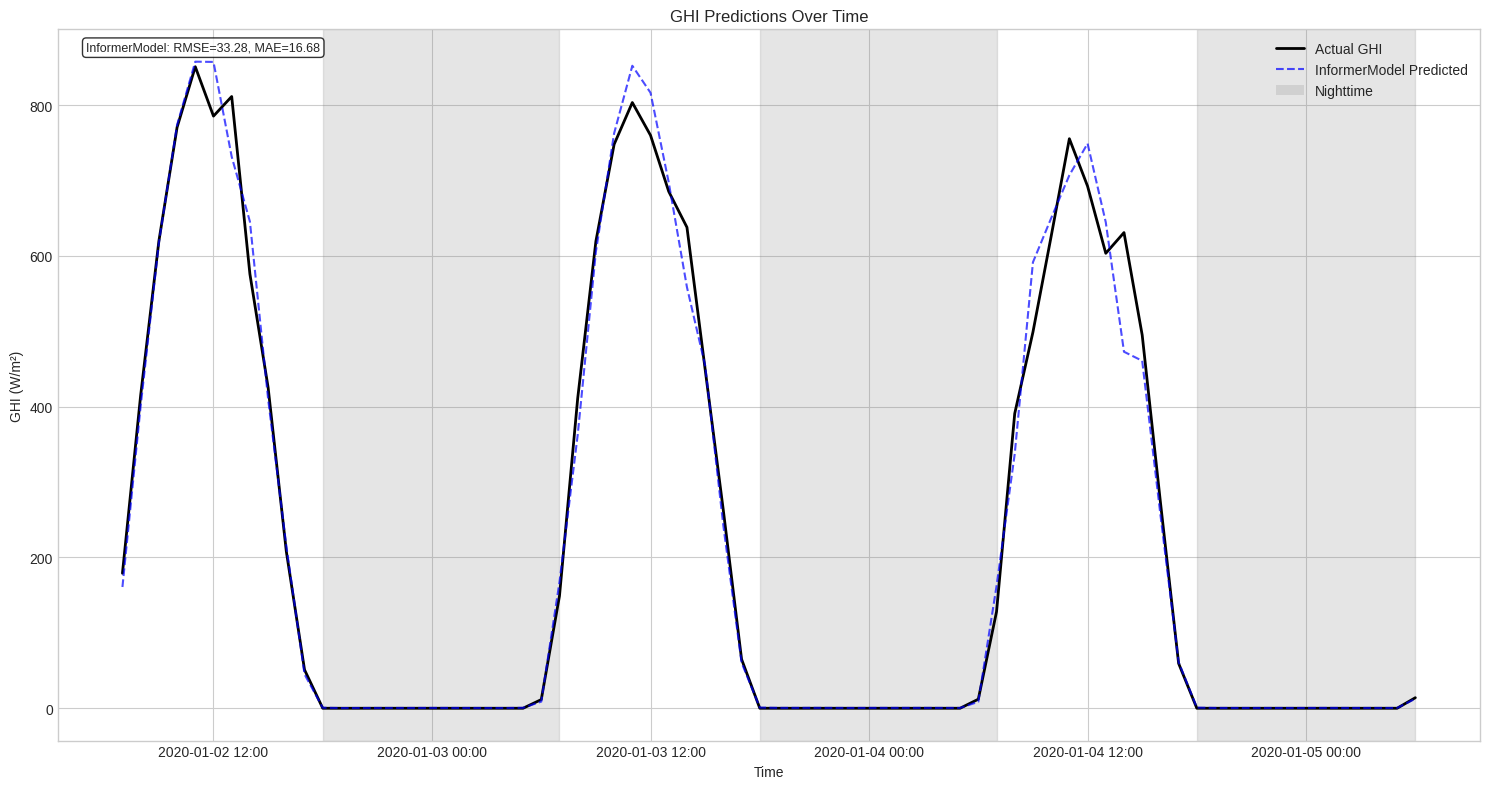

In [4]:
scaler = load_scalers(SCALER_PATH)
# Define target scaler from the data_metadata
target_scaler = scaler.get(f'{target_field}_scaler')
if target_scaler is None:
    print(f"Warning: No scaler found for target field '{target_field}'. Visualization may show scaled values.")

# Visualize the loaded model's predictions
print("Generating predictions visualization...")
model.eval()  # Set model to evaluation mode

# Create the visualization using the imported function
viz_fig = plot_predictions_over_time(
    models=[model],
    model_names=[model_type],
    data_loader=test_loader,
    target_scaler=target_scaler,
    num_samples=72,  # Adjust as needed
    start_idx=0       # Adjust as needed
)

# Display the plot if in a notebook environment
plt.show()

### 3.3 Check a Sample Batch

In [5]:
# Debug: Check a sample batch
batch = next(iter(test_loader))

# Check sample batch
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")
    elif isinstance(value, list):
        print(f"{key} length: {len(value)}")

# Extract dimensions from a batch (more reliable)
sample_temporal_features = batch['temporal_features']
sample_static_features = batch['static_features']
TEMPORAL_FEATURES_SHAPE = list(sample_temporal_features.shape)
STATIC_FEATURES_SHAPE = list(sample_static_features.shape)

# Check if we have 3D temporal features (batch, seq_len, features)
if len(sample_temporal_features.shape) == 3:
    temporal_dim = sample_temporal_features.shape[2]
else:
    # Handle 2D temporal features (batch, features)
    temporal_dim = sample_temporal_features.shape[1]

static_dim = sample_static_features.shape[1]

print(f"  Input dimensions determined from batch:")
print(f"  - Batch temporal_features shape: {TEMPORAL_FEATURES_SHAPE}")
print(f"  - Batch static_features shape: {STATIC_FEATURES_SHAPE}")
print(f"  - Temporal dimension: {temporal_dim}")
print(f"  - Static dimension: {static_dim}")

static_features shape: torch.Size([64, 3])
target shape: torch.Size([64])
temporal_features shape: torch.Size([64, 24, 19])
air_temperature shape: torch.Size([64, 24])
aod shape: torch.Size([64, 24])
cld_opd_dcomp shape: torch.Size([64, 24])
clearsky_ghi shape: torch.Size([64, 24])
cloud_type shape: torch.Size([64, 24])
nighttime_mask shape: torch.Size([64, 24])
relative_humidity shape: torch.Size([64, 24])
solar_zenith_angle shape: torch.Size([64, 24])
surface_albedo shape: torch.Size([64, 24])
total_precipitable_water shape: torch.Size([64, 24])
wind_speed shape: torch.Size([64, 24])
time_index_local length: 64
current_hour_sin shape: torch.Size([64])
current_hour_cos shape: torch.Size([64])
current_day_sin shape: torch.Size([64])
current_day_cos shape: torch.Size([64])
current_month_sin shape: torch.Size([64])
current_month_cos shape: torch.Size([64])
current_dow_sin shape: torch.Size([64])
current_dow_cos shape: torch.Size([64])
  Input dimensions determined from batch:
  - Batch t

## 4. Create Explainer

In [6]:
print(f"Creating explainer for model type: {model_type}...")
explainer = ShapExplainer(
    model=model,
    feature_names=temporal_features,
    static_feature_names=static_features
)
print(f"Explainer created: {type(explainer).__name__}")

Creating explainer for model type: InformerModel...
Explainer created: ShapExplainer


## 5. Prepare Background Data from Train Set and Samples from Test Set

We'll use the training data for background samples (SHAP baseline distribution) and test data for explanation samples.
This approach is more meaningful as it uses the distribution the model was trained on as the baseline.
Using the full training set can be computationally expensive, especially for methods like KernelSHAP,
so we select a subset of samples.

In [7]:
# --- Prepare background data from TRAIN set ---
print("Preparing background data from TRAIN set...")
train_temporal_samples = []
train_static_samples = []

# Choose a subset of training samples for background data
train_indices = np.random.choice(len(train_dataset), min(BACKGROUND_SIZE, len(train_dataset)), replace=False)

# Extract samples from train dataset
for idx in train_indices:
    train_sample = train_dataset[idx]

    # Get temporal features
    x_temporal_tensor = train_sample.get('temporal_features')
    if isinstance(x_temporal_tensor, torch.Tensor):
        train_temporal_samples.append(x_temporal_tensor.cpu().numpy())
    else:
        train_temporal_samples.append(x_temporal_tensor)

    # Get static features
    x_static_tensor = train_sample.get('static_features')
    if isinstance(x_static_tensor, torch.Tensor):
        train_static_samples.append(x_static_tensor.cpu().numpy())
    else:
        train_static_samples.append(x_static_tensor)

# Stack collected numpy arrays for background data
train_temporal_array = np.stack(train_temporal_samples, axis=0)
train_static_array = np.stack(train_static_samples, axis=0)

print(f"Prepared {train_temporal_array.shape[0]} background samples from training data.")
print(f"Background temporal data shape: {train_temporal_array.shape}")
print(f"Background static data shape: {train_static_array.shape}")

# --- Prepare samples to explain from TEST set ---
print(f"Preparing {N_SAMPLES} samples for explanation from TEST set...")
X_temporal_samples = []
X_static_samples = []
y_samples = []

# Determine valid indices based on nighttime mask (if available)
if use_mask_filtering:
    print("Filtering samples using nighttime_mask...")
    # Assume mask shape aligns with n_timesteps, handle potential multi-location later if needed
    # We need the mask value at the *target* time step, which is `start_index + lookback`
    mask_for_targets = nighttime_mask[test_dataset.lookback:]

    # Valid start indices are those where the corresponding target mask is False (daytime)
    # Need to adjust indices based on potential multi-location structure if mask is 2D
    if len(nighttime_mask.shape) == 1:
        # Simple case: 1D mask (applies to all locations or single location)
        valid_dataset_indices = [idx for idx in range(len(test_dataset))
                                if not mask_for_targets[idx // test_dataset.n_locations]] # Get timestep index
    elif len(nighttime_mask.shape) == 2 and nighttime_mask.shape[1] == test_dataset.n_locations:
        # 2D mask (timesteps, locations)
        valid_dataset_indices = [idx for idx in range(len(test_dataset))
                                if not mask_for_targets[idx // test_dataset.n_locations, idx % test_dataset.n_locations]]
    else:
        print(f"Warning: Unexpected nighttime_mask shape {nighttime_mask.shape}. Proceeding without filtering.")
        valid_dataset_indices = list(range(len(test_dataset)))

    if not valid_dataset_indices:
        raise ValueError("Error: No daytime samples found after filtering with nighttime_mask.")
    print(f"Found {len(valid_dataset_indices)} valid daytime samples out of {len(test_dataset)} total.")
else:
    print("Skipping nighttime filtering (mask not available or disabled).")
    valid_dataset_indices = list(range(len(test_dataset)))

# Determine the number of samples to actually select
num_available = len(valid_dataset_indices)
num_to_select = min(N_SAMPLES, num_available)

if num_to_select <= 0:
    raise ValueError(f"Error: Cannot select {N_SAMPLES} samples. Only {num_available} valid samples available.")

print(f"Selecting {num_to_select} samples for explanation from {num_available} valid samples...")

# Randomly choose indices from the valid ones
selected_indices = np.random.choice(valid_dataset_indices, num_to_select, replace=False)

# Retrieve samples directly from the dataset using selected indices
for idx in selected_indices:
    sample = test_dataset[idx] # __getitem__ returns a dict

    # Ensure sample components are tensors before converting to numpy
    x_temporal_tensor = sample.get('temporal_features')
    x_static_tensor = sample.get('static_features')
    y_tensor = sample.get('target')

    # Convert tensors to numpy arrays (move to CPU first if on GPU)
    if isinstance(x_temporal_tensor, torch.Tensor):
        X_temporal_samples.append(x_temporal_tensor.cpu().numpy())
    else:
        X_temporal_samples.append(x_temporal_tensor) # Assume already numpy or compatible

    if isinstance(x_static_tensor, torch.Tensor):
        X_static_samples.append(x_static_tensor.cpu().numpy())
    else:
        X_static_samples.append(x_static_tensor)

    if isinstance(y_tensor, torch.Tensor):
        y_samples.append(y_tensor.cpu().numpy())
    else:
        y_samples.append(y_tensor)

# Stack collected numpy arrays
if not X_temporal_samples:
    print("Error: No samples collected after filtering and selection.")
else:
    X_temporal_array = np.stack(X_temporal_samples, axis=0)
    X_static_array = np.stack(X_static_samples, axis=0)
    y_array = np.stack(y_samples, axis=0)

    print(f"Prepared {X_temporal_array.shape[0]} samples from test data for explanation.")
    print(f"Test temporal data shape: {X_temporal_array.shape}")
    print(f"Test static data shape: {X_static_array.shape}")

Preparing background data from TRAIN set...
Prepared 20 background samples from training data.
Background temporal data shape: (20, 24, 19)
Background static data shape: (20, 3)
Preparing 1000 samples for explanation from TEST set...
Filtering samples using nighttime_mask...
Found 458183 valid daytime samples out of 919800 total.
Selecting 1000 samples for explanation from 458183 valid samples...
Prepared 1000 samples from test data for explanation.
Test temporal data shape: (1000, 24, 19)
Test static data shape: (1000, 3)


## 6. Run SHAP Explanation and Visualize Results

### 6.1 SHAP Explanation - Feature Names Preparation

In [8]:
# Determine which explainer type we're using and proceed accordingly
print(f"--- Running SHAP Explanation ({SHAP_ALGORITHM}) ---")

# Print shapes for debugging
print(f"X_temporal_array shape: {X_temporal_array.shape}")
if X_static_array is not None:
    print(f"X_static_array shape: {X_static_array.shape}")

# Extract shape information for feature naming
if len(X_temporal_array.shape) == 3:  # (batch, sequence, features)
    batch_size, seq_len, n_features = X_temporal_array.shape
    print(f"Detected shape: batch_size={batch_size}, seq_len={seq_len}, n_features={n_features}")

    # Create meaningful feature names by combining temporal feature names with time steps
    feature_names_flat = []
    for t in range(seq_len):
        for feat_idx, feat_name in enumerate(temporal_features):
            # Create more descriptive feature names with time indices
            feature_names_flat.append(f"{feat_name}_t-{seq_len-1-t}")
    print(f"Created {len(feature_names_flat)} feature names")
else:
    print(f"Data array shape: {X_temporal_array.shape}")
    n_features = len(temporal_features)
    seq_len = X_temporal_array.shape[1] // n_features
    print(f"Inferred shape: seq_len={seq_len}, n_features={n_features}")

    # Create meaningful feature names
    feature_names_flat = []
    for t in range(seq_len):
        for feat_idx, feat_name in enumerate(temporal_features):
            feature_names_flat.append(f"{feat_name}_t-{seq_len-1-t}")
    print(f"Created {len(feature_names_flat)} feature names")

--- Running SHAP Explanation (kernel) ---
X_temporal_array shape: (1000, 24, 19)
X_static_array shape: (1000, 3)
Detected shape: batch_size=1000, seq_len=24, n_features=19
Created 456 feature names


### 6.2 SHAP Explanation - Background Data Preparation

In [9]:
# Use train data for background - no flattening needed since model forward handles this
X_temporal_bg = train_temporal_array
X_static_bg = train_static_array

# Create the proper tuple format expected by initialize_explainer
background_data = (X_temporal_bg, X_static_bg)

print(f"Initializing SHAP explainer with {SHAP_ALGORITHM} algorithm using {X_temporal_bg.shape[0]} background samples from TRAIN set...")
print(f"Background data temporal shape: {X_temporal_bg.shape}")
if X_static_bg is not None:
    print(f"Background data static shape: {X_static_bg.shape}")

Initializing SHAP explainer with kernel algorithm using 20 background samples from TRAIN set...
Background data temporal shape: (20, 24, 19)
Background data static shape: (20, 3)


### 6.3 SHAP Explanation - Model Wrapper Setup

In [10]:
# Define the custom model wrapper function
# Note: This needs X_static_explain to be defined in the scope before this cell is run
# We will define X_static_explain in the next step (6.4) and then initialize the explainer.
# Make sure model is in evaluation mode to disable batch norm statistics updates
model.eval()

def custom_model_wrapper(x_input, return_pytorch_tensor=False):
    """Custom wrapper for the model that passes inputs directly to model, handling 1D/2D inputs.

    Args:
        x_input: Input data, can be numpy array or PyTorch tensor
        return_pytorch_tensor: If True, return PyTorch tensor (for GradientExplainer),
                              otherwise return numpy array (for KernelExplainer)
    """
    # Handle both numpy arrays and PyTorch tensors as input
    if isinstance(x_input, torch.Tensor):
        x_tensor = x_input
        is_pytorch_input = True
    else:
        # Ensure input is numpy array
        x_input_np = np.asarray(x_input)
        is_pytorch_input = False

        # Add batch dimension if input is 1D (single instance)
        if x_input_np.ndim == 1:
            x_input_np = x_input_np.reshape(1, -1)
            is_single_instance = True
        else:
            is_single_instance = False

        # Create a tensor from input
        x_tensor = torch.tensor(x_input_np, dtype=torch.float32).to(device)

    # --- Reshape flattened input for the model ---
    # SHAP passes flattened input (batch_size, seq_len * n_features) for KernelExplainer
    # or already 3D input (batch_size, seq_len, n_features) for GradientExplainer
    # Check if reshaping is needed
    if len(x_tensor.shape) == 2 and x_tensor.shape[1] == len(temporal_features) * LOOKBACK:
        # Input is flattened, reshape to 3D
        batch_size = x_tensor.shape[0]
        expected_n_temporal_features = len(temporal_features) # Get number of features from global scope
        expected_seq_len = LOOKBACK # Get lookback/seq_len from global scope

        # Check if the flattened dimension matches expectations
        if x_tensor.shape[1] != expected_seq_len * expected_n_temporal_features:
            raise ValueError(
                f"Input tensor flattened dimension ({x_tensor.shape[1]}) does not match "
                f"expected ({expected_seq_len} * {expected_n_temporal_features}). Check LOOKBACK and temporal_features."
            )

        x_tensor_reshaped = x_tensor.reshape(batch_size, expected_seq_len, expected_n_temporal_features)
    else:
        # Input is already in expected shape
        x_tensor_reshaped = x_tensor
    # ---------------------------------------------

    # Get static features if available
    static_tensor = None
    if X_static_array is not None:
        # Important: we need to repeat static features for each row in x_tensor
        # Get a slice of static features with the right size
        # The batch_size here is determined by the input x_tensor, which might be different from the original explain batch
        current_batch_size = x_tensor_reshaped.shape[0] # Use reshaped tensor's batch size

        # Select the appropriate static features based on input indices
        # If input x_input corresponds to rows k, k+1,... from the original dataset,
        # we need static features for rows k, k+1, ...
        # SHAP doesn't easily provide original indices, so we might need to rely on repetition
        # or assume the order matches the original data slice used for explanation.

        # Use the indices corresponding to the explanation data slice
        # Ensure X_static_explain is defined before this function is called!
        static_features_to_use = X_static_explain

        # Repeat static features if the model wrapper receives a larger batch than available static data
        # This usually happens during SHAP's background processing
        if current_batch_size > static_features_to_use.shape[0]:
            repeat_factor = (current_batch_size // static_features_to_use.shape[0]) + 1
            expanded_static = np.repeat(static_features_to_use, repeat_factor, axis=0)
            static_features_to_use = expanded_static[:current_batch_size]
        elif current_batch_size < static_features_to_use.shape[0]:
                # If processing a single instance or smaller batch, take the corresponding static features
                # This assumes the order in x_input matches the order in X_temporal_explain
                # If it's a single instance, take the first row (this might be an approximation)
                if not is_pytorch_input and is_single_instance:
                    static_features_to_use = static_features_to_use[[0], :] # Take first row, keep 2D
                else: # Otherwise, take the first batch_size rows
                    static_features_to_use = static_features_to_use[:current_batch_size]

        static_tensor = torch.tensor(
            static_features_to_use,
            dtype=torch.float32
        ).to(device)

    # Forward pass through the model
    if return_pytorch_tensor:
        # For GradientExplainer mode - return tensor directly (with gradient tracking)
        outputs = model(x_tensor_reshaped, static_tensor)
        # Ensure outputs have shape (batch_size, num_outputs)
        if len(outputs.shape) == 1:
            # If output is 1D (e.g., single output value per sample), add a dimension
            outputs = outputs.unsqueeze(1)  # Add a dimension to make it (batch_size, 1)
        return outputs
    else:
        # For KernelExplainer mode - return numpy array (no gradient tracking)
        with torch.no_grad():
            # Use the reshaped tensor here
            output = model(x_tensor_reshaped, static_tensor)

        # Return numpy array
        result = output.cpu().numpy()

        # --- Ensure output is at least 1D for SHAP ---
        final_result = np.atleast_1d(result)

        # SHAP KernelExplainer expects shape (n_outputs,) for single instance explanations
        # or (batch_size, n_outputs) for batch explanations.
        return final_result

print("Custom model wrapper defined.")

Custom model wrapper defined.


### 6.4 SHAP Explanation - Prepare Explanation Data & Initialize Explainer

In [11]:
# --- 1. Prepare Data for Explanation ---
# Explain a subset of the samples (SHAP can be slow)
explain_size = min(N_SAMPLES, X_temporal_array.shape[0])
explain_indices = np.random.choice(X_temporal_array.shape[0], explain_size, replace=False)

# Get temporal data for explanation
X_temporal_explain = X_temporal_array[explain_indices]
print(f"Selected {explain_size} samples for explanation.")
print(f"Explanation temporal data shape: {X_temporal_explain.shape}")

# Get corresponding static data (if available)
X_static_explain = X_static_array[explain_indices]
print(f"Explanation static data shape: {X_static_explain.shape}")

# --- 2. Set Wrapper & Initialize Explainer ---
# custom_model_wrapper should be defined in the previous cell
# Set the custom model wrapper (it now has access to X_static_explain)
print("Setting custom model wrapper...")
explainer.set_custom_model_wrapper(custom_model_wrapper)

# Prepare background data for explainer initialization
# background_data tuple was defined in cell 6.2
X_temporal_bg_init = background_data[0] # Extract temporal part
# Flatten background temporal data if using KernelExplainer
if SHAP_ALGORITHM == 'kernel' and len(X_temporal_bg_init.shape) == 3:
    print("Flattening background temporal data for KernelExplainer initialization...")
    X_temporal_bg_init = X_temporal_bg_init.reshape(X_temporal_bg_init.shape[0], -1)
    print(f"Flattened background shape for init: {X_temporal_bg_init.shape}")

# Initialize the explainer using the (potentially flattened) background temporal data
print("Initializing explainer...")
explainer.initialize_explainer((X_temporal_bg_init, background_data[1]), algorithm=SHAP_ALGORITHM)
print("Explainer initialized.")

Selected 1000 samples for explanation.
Explanation temporal data shape: (1000, 24, 19)
Explanation static data shape: (1000, 3)
Setting custom model wrapper...
Custom model wrapper set successfully.
Flattening background temporal data for KernelExplainer initialization...
Flattened background shape for init: (20, 456)
Initializing explainer...
Using custom model wrapper for SHAP explainer
Explainer initialized.


### 6.5 SHAP Explanation - Calculate SHAP Values

In [12]:
# Prepare explanation data tuple
# Use the X_temporal_explain and X_static_explain defined above
explain_data = (X_temporal_explain, X_static_explain)

# Special preprocessing for KernelExplainer which requires 2D inputs
# Use the variables defined in the previous cell
if SHAP_ALGORITHM == 'kernel' and len(X_temporal_explain.shape) == 3:
    print("Flattening temporal data for KernelExplainer (requires 2D input)...")
    X_temporal_flat = X_temporal_explain.reshape(X_temporal_explain.shape[0], -1)
    # Recreate explain_data tuple with flattened temporal data
    explain_data = (X_temporal_flat, X_static_explain)
    print(f"Flattened shape for KernelExplainer: {X_temporal_flat.shape}")

# Calculate SHAP values
print(f"Calculating SHAP values for {explain_size} samples... (This might take a while)")
shap_values = explainer.explain_batch(explain_data)
print(f"SHAP values calculated. SHAP values shape: {shap_values.shape}")

Flattening temporal data for KernelExplainer (requires 2D input)...
Flattened shape for KernelExplainer: (1000, 456)
Calculating SHAP values for 1000 samples... (This might take a while)


  0%|          | 0/1000 [00:00<?, ?it/s]

SHAP values calculated. SHAP values shape: (1000, 456)


### 6.6 SHAP Explanation - Prepare Visualization Data

In [13]:
# For visualization, we need to handle the data differently based on algorithm
print(f"Preparing visualization data for {SHAP_ALGORITHM} algorithm...")

if SHAP_ALGORITHM == 'gradient':
    # For gradient algorithm, we try to preserve the 3D structure if possible
    if len(X_temporal_explain.shape) == 3 and len(shap_values.shape) == 3:
        print(f"Using 3D SHAP values with shape {shap_values.shape} for temporal analysis")
        # Create a 3D-aware visualization

        # For summary plot we still need to flatten data
        X_flat = X_temporal_explain.reshape(explain_size, -1)
        shap_values_flat = shap_values.reshape(explain_size, -1)

        # Save the original 3D structure for possible time-based visualizations
        X_3d = X_temporal_explain
        shap_values_3d = shap_values

        print(f"Also created flattened representation - X_flat: {X_flat.shape}, shap_values_flat: {shap_values_flat.shape}")
    else:
        print(f"SHAP values shape: {shap_values.shape} doesn't match expected 3D structure, flattening data")
        # Fall back to flattening if structures don't match
        X_flat = X_temporal_explain.reshape(explain_size, -1) if len(X_temporal_explain.shape) > 2 else X_temporal_explain
        shap_values_flat = shap_values.reshape(explain_size, -1) if len(shap_values.shape) > 2 else shap_values
else:
    # For kernel algorithm, data is always flattened
    if len(X_temporal_explain.shape) == 3:  # 3D data (batch, seq, features)
        X_flat = X_temporal_explain.reshape(explain_size, -1)
        shap_values_flat = shap_values.reshape(explain_size, -1)
    elif len(X_temporal_explain.shape) > 3:  # e.g., CNN input (batch, seq, h, w)
        X_flat = X_temporal_explain.reshape(explain_size, -1)
        shap_values_flat = shap_values.reshape(explain_size, -1)
        # Create meaningful feature names for flattened data if possible
        # This part might need customization based on the exact CNN structure
        feature_names_flat = [f'pixel_{i}' for i in range(X_flat.shape[1])]
    else: # Already 2D data (batch, features)
        X_flat = X_temporal_explain
        shap_values_flat = shap_values

# Add static features if they exist
if X_static_array is not None:
    # Use the actual static explain data from our tuple
    print("Note: Static feature SHAP values might require model-specific handling.")
    # Example: Concatenate static features if explainer provides values for them
    # X_flat = np.concatenate((X_flat, X_static_explain), axis=1)
    # feature_names_flat += static_features
    # shap_values_flat = np.concatenate((shap_values_flat, shap_values_static), axis=1) # If available

# Ensure feature names match dimensions
if len(feature_names_flat) != X_flat.shape[1]:
    print(f"Warning: Mismatch between number of feature names ({len(feature_names_flat)}) and data dimension ({X_flat.shape[1]}). Adjusting feature names.")
    # Fallback: generic feature names
    feature_names_flat = [f'feature_{i}' for i in range(X_flat.shape[1])]

Preparing visualization data for kernel algorithm...
Note: Static feature SHAP values might require model-specific handling.


### 6.7 SHAP Explanation - Create Summary Plot

Generating SHAP summary plot...
Final shapes - SHAP values: (1000, 456), X_flat: (1000, 456), feature names: 456


/tmp/ipykernel_585660/43095459.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


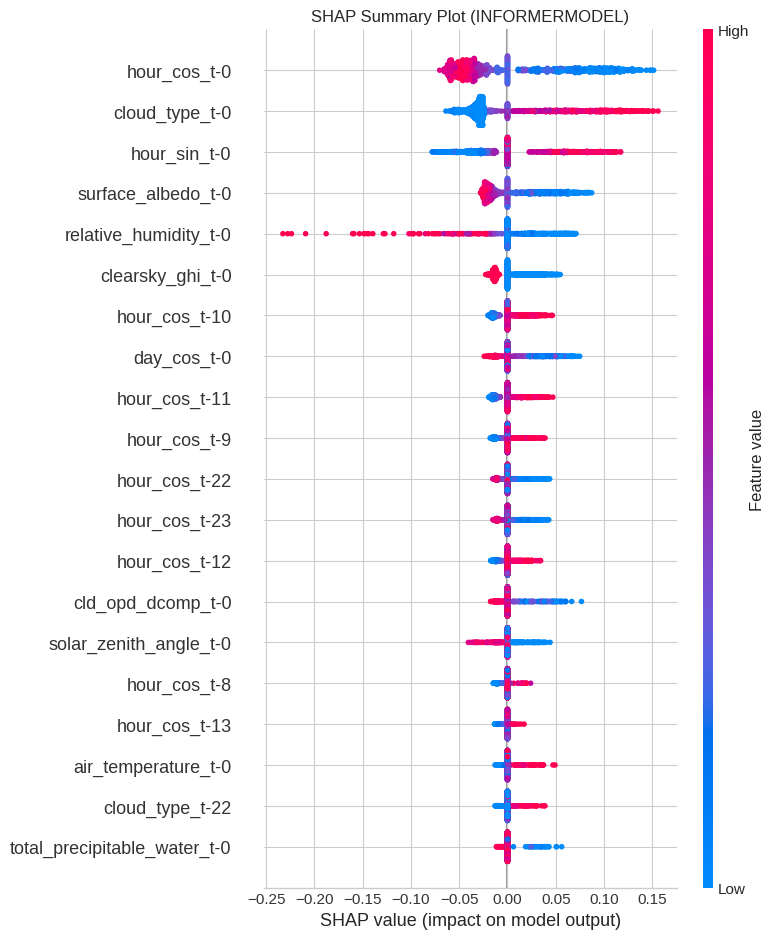

Summary plot saved to explainability/InformerModel_shap_summary_20250501_052648.png


In [14]:
# Plot SHAP Summary Plot
print("Generating SHAP summary plot...")
plt.figure()

# Ensure shap_values and X_flat match in dimensions and are properly shaped for summary_plot
# If we get multi-dimensional arrays, we need to flatten them correctly
if len(shap_values_flat.shape) > 2:
    print(f"Reshaping multi-dimensional SHAP values from {shap_values_flat.shape} to 2D")
    shap_values_flat = shap_values_flat.reshape(shap_values_flat.shape[0], -1)

if len(X_flat.shape) > 2:
    print(f"Reshaping multi-dimensional X_flat from {X_flat.shape} to 2D")
    X_flat = X_flat.reshape(X_flat.shape[0], -1)

# Check if dimensions match
if shap_values_flat.shape[1] != X_flat.shape[1]:
    print(f"Warning: Mismatch between SHAP values shape {shap_values_flat.shape} and feature shape {X_flat.shape}")
    # Adjust feature dimensions if needed
    min_dim = min(shap_values_flat.shape[1], X_flat.shape[1])
    shap_values_flat = shap_values_flat[:, :min_dim]
    X_flat = X_flat[:, :min_dim]
    feature_names_flat = feature_names_flat[:min_dim]

print(f"Final shapes - SHAP values: {shap_values_flat.shape}, X_flat: {X_flat.shape}, feature names: {len(feature_names_flat)}")

shap.summary_plot(
    shap_values_flat,
    X_flat,
    feature_names=feature_names_flat,
    max_display=20,
    show=False
)
plt.title(f'SHAP Summary Plot ({model_type.upper()})')
plt.tight_layout()
summary_plot_path = output_dir / f"{model_type}_shap_summary_{timestamp}.png"
plt.savefig(summary_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"Summary plot saved to {summary_plot_path}")

### 6.8 SHAP Explanation - Feature Importance Plot

Generating feature importance plot...
Feature importance shape: (456,), feature names length: 456


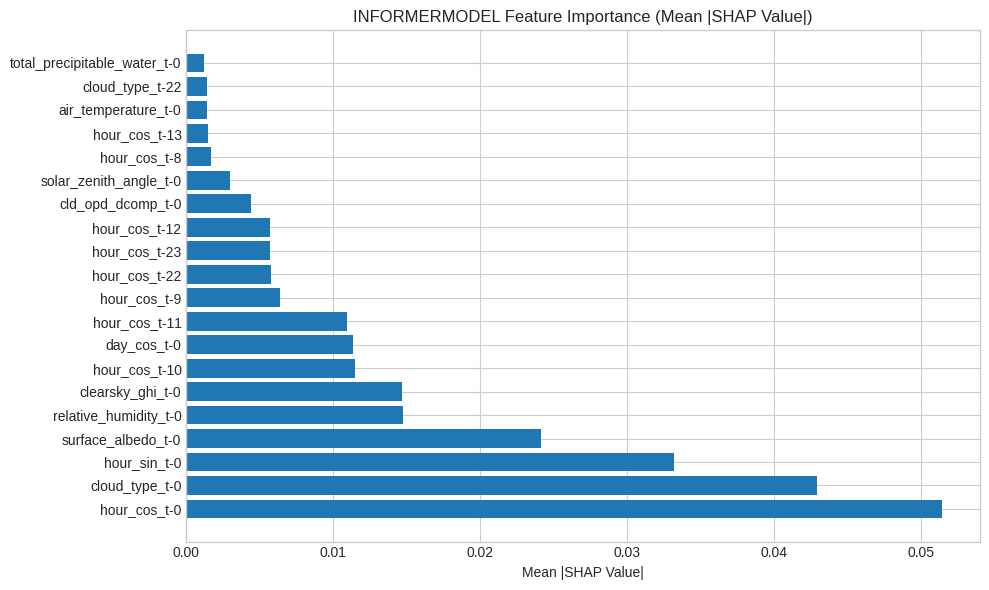

Feature importance plot saved to explainability/InformerModel_feature_importance_20250501_052648.png


In [15]:
# Plot Feature Importance Plot
print("Generating feature importance plot...")

# Calculate mean absolute SHAP value for each feature
# Ensure feature_importance is 1-dimensional
feature_importance = np.abs(shap_values_flat).mean(axis=0)
if len(feature_importance.shape) > 1:
    print(f"Flattening feature_importance from {feature_importance.shape}")
    feature_importance = feature_importance.flatten()

print(f"Feature importance shape: {feature_importance.shape}, feature names length: {len(feature_names_flat)}")

# Match feature names to importance values
if len(feature_names_flat) > len(feature_importance):
    print(f"Truncating feature names from {len(feature_names_flat)} to {len(feature_importance)}")
    feature_names_adjusted = feature_names_flat[:len(feature_importance)]
elif len(feature_names_flat) < len(feature_importance):
    print(f"Truncating importance values from {len(feature_importance)} to {len(feature_names_flat)}")
    feature_importance = feature_importance[:len(feature_names_flat)]
    feature_names_adjusted = feature_names_flat
else:
    feature_names_adjusted = feature_names_flat

# Create a new shap_values array that matches the expected format for plot_feature_importance
# The function expects the original shap_values array to calculate the mean abs value internally
shap_values_adjusted = np.zeros((explain_size, len(feature_names_adjusted)))
for i in range(explain_size):
    shap_values_adjusted[i] = feature_importance  # Each row is the same

# Now plot using the properly dimensioned arrays
fig = explainer.plot_feature_importance(
    shap_values=shap_values_adjusted,  # Pass adjusted shap values
    feature_names=feature_names_adjusted,  # Pass matched feature names
    max_display=20,
    show=False,
    title=f"{model_type.upper()} Feature Importance (Mean |SHAP Value|)"
)
importance_plot_path = output_dir / f"{model_type}_feature_importance_{timestamp}.png"
fig.savefig(importance_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)
print(f"Feature importance plot saved to {importance_plot_path}")

### 6.9 SHAP Explanation - Temporal Analysis (for Both Algorithms)

Attempting temporal analysis for kernel algorithm...
Reshaping kernel SHAP values from (1000, 456) back to 3D (1000, 24, 19)
Successfully reshaped kernel SHAP values for temporal analysis
Generating temporal analysis plots...


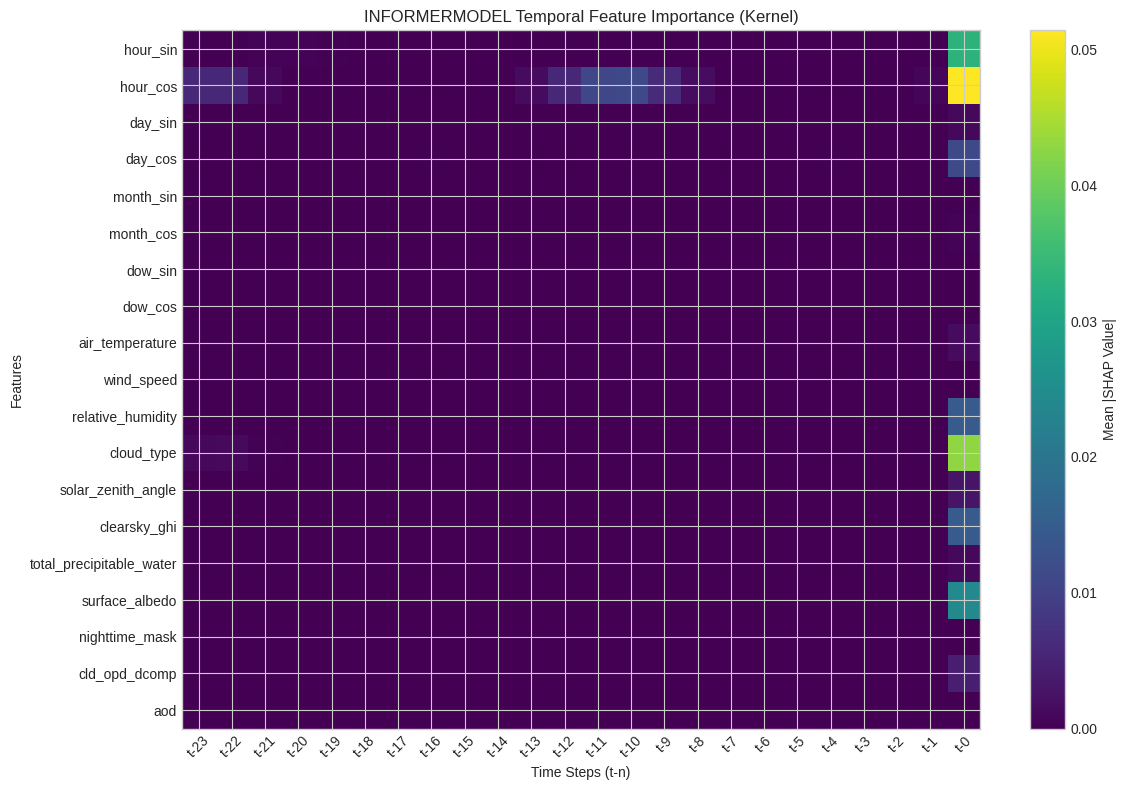

Temporal analysis plot saved to explainability/InformerModel_kernel_temporal_importance_20250501_052648.png


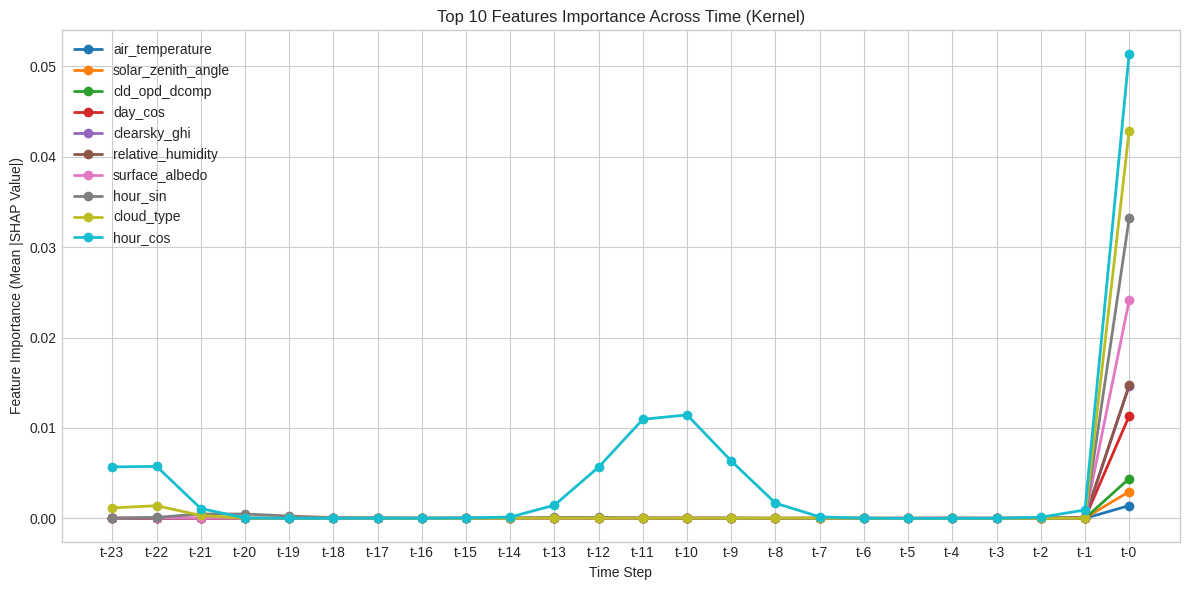

Top features temporal analysis saved to explainability/InformerModel_kernel_top_features_temporal_20250501_052648.png


In [16]:
# Special temporal visualization that works for both gradient and kernel algorithms
print(f"Attempting temporal analysis for {SHAP_ALGORITHM} algorithm...")

# Check if we have 3D data for gradient algorithm
has_3d_data = SHAP_ALGORITHM == 'gradient' and 'X_3d' in locals() and 'shap_values_3d' in locals()

# For kernel algorithm, we need to reshape the flattened values back to 3D
if SHAP_ALGORITHM == 'kernel' and not has_3d_data:
    if len(X_temporal_explain.shape) == 3 and len(shap_values.shape) == 2:
        # Get original 3D dimensions
        batch_size, seq_len, n_features = X_temporal_explain.shape

        # Check if shap_values can be reshaped to match
        if shap_values.shape[1] == seq_len * n_features:
            print(f"Reshaping kernel SHAP values from {shap_values.shape} back to 3D ({batch_size}, {seq_len}, {n_features})")
            try:
                # Reshape flattened SHAP values back to 3D for temporal analysis
                shap_values_3d = shap_values.reshape(batch_size, seq_len, n_features)
                X_3d = X_temporal_explain
                has_3d_data = True
                print("Successfully reshaped kernel SHAP values for temporal analysis")
            except Exception as e:
                print(f"Error reshaping kernel SHAP values: {e}")
                has_3d_data = False
        else:
            print(f"Cannot reshape kernel SHAP values: dimensions don't match. SHAP values shape: {shap_values.shape}, expected features: {seq_len * n_features}")
            has_3d_data = False
    else:
        print(f"Cannot perform temporal analysis with kernel algorithm: input or SHAP values not in expected format")
        print(f"X_temporal_explain shape: {X_temporal_explain.shape}, shap_values shape: {shap_values.shape}")
        has_3d_data = False

# Generate temporal visualization if we have 3D data (either from gradient or reshaped kernel)
if has_3d_data:
    print("Generating temporal analysis plots...")

    # Calculate feature importance across time steps
    batch_size, seq_len, n_features = shap_values_3d.shape
    temporal_importance = np.abs(shap_values_3d).mean(axis=0)  # Shape: (seq_len, n_features)

    # Create a plot showing feature importance across time steps
    plt.figure(figsize=(12, 8))

    # Create a heatmap of temporal importance
    plt.imshow(temporal_importance.T, aspect='auto', cmap='viridis')
    plt.colorbar(label='Mean |SHAP Value|')

    # Set axis labels and ticks
    plt.xlabel('Time Steps (t-n)')
    plt.ylabel('Features')
    # X-axis ticks are time steps from past to present
    time_labels = [f't-{seq_len-1-i}' for i in range(seq_len)]
    plt.xticks(range(seq_len), time_labels, rotation=45)
    # Y-axis ticks are feature names
    plt.yticks(range(n_features), temporal_features)

    plt.title(f'{model_type.upper()} Temporal Feature Importance ({SHAP_ALGORITHM.capitalize()})')
    plt.tight_layout()

    # Save the plot
    temporal_plot_path = output_dir / f"{model_type}_{SHAP_ALGORITHM}_temporal_importance_{timestamp}.png"
    plt.savefig(temporal_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Temporal analysis plot saved to {temporal_plot_path}")

    # Create line plots for top features across time
    # Identify top N features based on overall importance
    top_n = 10
    top_features_idx = np.argsort(np.mean(temporal_importance, axis=0))[-top_n:]

    plt.figure(figsize=(12, 6))
    for i, feat_idx in enumerate(top_features_idx):
        feat_name = temporal_features[feat_idx]
        plt.plot(time_labels, temporal_importance[:, feat_idx],
                marker='o', linewidth=2, label=feat_name)

    plt.xlabel('Time Step')
    plt.ylabel('Feature Importance (Mean |SHAP Value|)')
    plt.title(f'Top {top_n} Features Importance Across Time ({SHAP_ALGORITHM.capitalize()})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    top_features_path = output_dir / f"{model_type}_{SHAP_ALGORITHM}_top_features_temporal_{timestamp}.png"
    plt.savefig(top_features_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Top features temporal analysis saved to {top_features_path}")
else:
    print("Skipping temporal analysis (requires 3D data structures)")

### 7. Sensitivity Analysis (Alternative to SHAP)

--- Running Sensitivity Analysis ---
Sensitivity analysis complete.
Generating feature sensitivity plot...


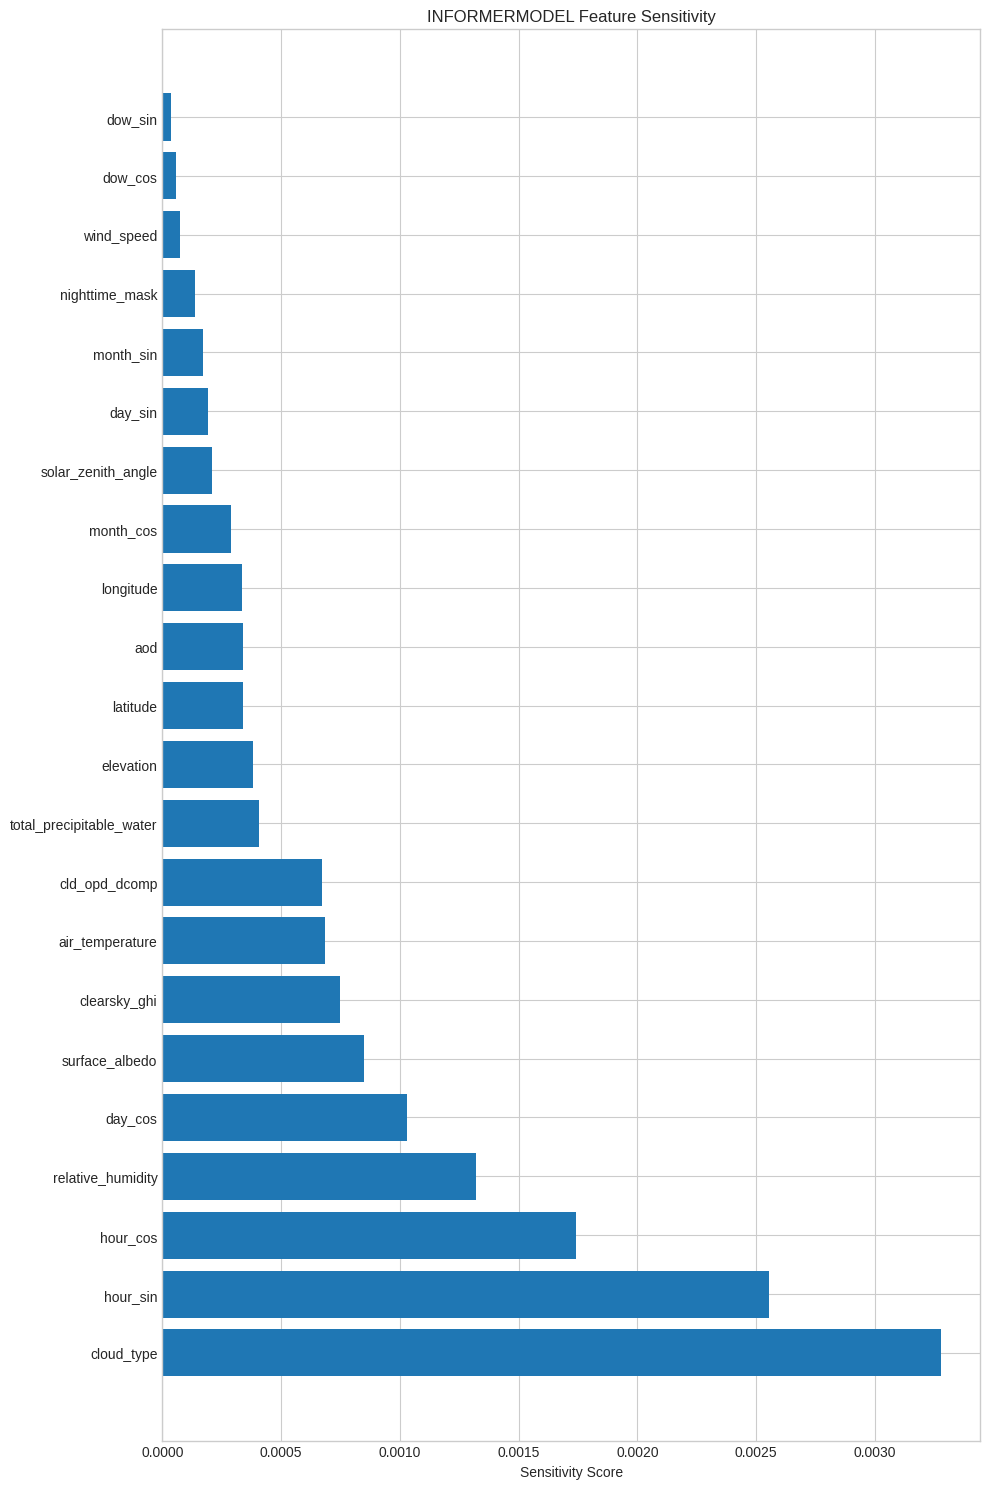

Feature sensitivity plot saved to explainability/InformerModel_sensitivity.png
Sensitivity data saved to explainability/InformerModel_sensitivity.csv
Top 10 Features by Sensitivity:
                     Feature  Sensitivity
11                cloud_type     0.003278
0                   hour_sin     0.002552
1                   hour_cos     0.001740
10         relative_humidity     0.001319
3                    day_cos     0.001031
15            surface_albedo     0.000849
13              clearsky_ghi     0.000746
8            air_temperature     0.000683
17             cld_opd_dcomp     0.000672
14  total_precipitable_water     0.000407


In [17]:
print("--- Running Sensitivity Analysis ---")

explainer = SensitivityAnalyzer(model, temporal_features, static_features)

# Analyze feature sensitivity
sensitivity_df = explainer.analyze_feature_sensitivity(
    X_temporal_array,
    X_static_array,
    perturbation=0.1, # How much to perturb features
    n_samples=min(10, X_temporal_array.shape[0]) # Number of samples to base analysis on
)
print("Sensitivity analysis complete.")

# Plot feature sensitivity
print("Generating feature sensitivity plot...")
fig = explainer.plot_feature_sensitivity(
    sensitivity_df,
    max_display=50,
    show=False,
    title=f"{model_type.upper()} Feature Sensitivity"
)
sensitivity_plot_path = output_dir / f"{model_type}_sensitivity.png"
fig.savefig(sensitivity_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)
print(f"Feature sensitivity plot saved to {sensitivity_plot_path}")

# Save sensitivity data
sensitivity_csv_path = output_dir / f"{model_type}_sensitivity.csv"
sensitivity_df.to_csv(sensitivity_csv_path, index=False)
print(f"Sensitivity data saved to {sensitivity_csv_path}")
print("Top 10 Features by Sensitivity:")
print(sensitivity_df.head(10))